## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [1]:
import glob
import numpy as np
import scipy as sp
import scipy.io
import matplotlib.pyplot as plt

In [2]:
import os
import os.path
import scipy.signal

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [4]:
def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

In [5]:
def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]


In [6]:
ref_contents = sp.io.loadmat('./datasets/troika/training_data/REF_01_TYPE01.mat')
sorted(ref_contents.keys())

['BPM0', '__globals__', '__header__', '__version__']

In [7]:
#Scipy loadmat reference -- https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.loadmat.html
#how to read tags from .mat binary file

In [8]:
def LoadTroikaRefFile(ref_fl):
    """
    Loads and extracts reference from a troika reference file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika ref .mat file.

    Returns:
        #numpy arrays for ppg, accx, accy, accz signals.
    """
    refdata = sp.io.loadmat(ref_fl)['BPM0']
    return refdata[2:]


In [9]:

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

In [10]:
def FeatureExtraction(ppg, accx, accy, accz):
    """ 
    This function creates features 
    """

    fs = 125
    n = len(ppg) * 4
    # applying fast Fourier transform
    freqs = np.fft.rfftfreq(n, 1/fs)
    fft = np.abs(np.fft.rfft(ppg,n))
    fft[freqs <= 40/60.0] = 0.0
    fft[freqs >= 240/60.0] = 0.0
    
    ## calculating L2 norm
    acc_mag = np.sqrt(accx**2 + accy**2 + accz**2)
    acc_fft = np.abs(np.fft.rfft(acc_mag, n))
    acc_fft[freqs <= 40/60.0] = 0.0
    acc_fft[freqs >= 240/60.0] = 0.0
    
    ppg_feature = freqs[np.argmax(fft)]
    acc_feature = freqs[np.argmax(acc_fft)]
    
    return (np.array([ppg_feature, acc_feature]), ppg, accx, accy, accz)


In [11]:
def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    global reg
    reg = ModelRegression()
    
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)


In [12]:
def RunPulseRateAlgorithm(data_fl, ref_fl):
    ''' Main algorithm for pulse rate estimation '''
    ''' Returns errors and confidence '''
    
    fs = 125
    window_len = 10
    window_shift = 2 # from readme.md produces an output at least every 2 seconds. 
    
    # Load data using LoadTroikaDataFile
    #ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    sig = LoadTroikaDataFile(data_fl)
    
    # Load reference data
    ref = LoadTroikaRefFile(ref_fl)
    ref = np.array([x[0] for x in ref])
    
    # get subject name from data
    subject_name = os.path.basename(data_fl).split('.')[0]
    
    # Identify signal markers from the received signal data 
    start_indxs, end_indxs = get_indxs(sig.shape[1], len(ref), fs, window_len, window_shift)
    targets, features, sigs, subs = [], [], [], []
    
    for i, s in enumerate(start_indxs):
        start_i =  start_indxs[i]
        end_i = end_indxs[i]

        ppg = sig[0, start_i:end_i]            
        accx = sig[1, start_i:end_i]
        accy = sig[2, start_i:end_i]
        accz = sig[3, start_i:end_i]

        # apply filters to each signal
        ppg = BandpassFilter(ppg)
        accx = BandpassFilter(accx)
        accy = BandpassFilter(accy)
        accz = BandpassFilter(accz)
 
        # create the features
        feature, ppg, accx, accy, accz = FeatureExtraction(ppg, accx, accy, accz)

        sigs.append([ppg, accx, accy, accz])
        targets.append(ref[i])
        features.append(feature)
        subs.append(subject_name)

    # Compute pulse rate estimates and estimation confidence.
    errors, confidence = [], []
    
    for i, feature in enumerate(features):
        # make a prediction
        est = reg.predict(np.reshape(feature, (1, -1)))[0]
        ppg, accx, accy, accz = sigs[i]        
        
        n = len(ppg) * 4
        freqs = np.fft.rfftfreq(n, 1/fs)
        fft = np.abs(np.fft.rfft(ppg,n))
        fft[freqs <= 40/60.0] = 0.0 
        fft[freqs >= 240/60.0] = 0.0
    
        est_fs = est / 55.0
        fs_win = 30  / 60.0
        fs_win_e = (freqs >= est_fs - fs_win) & (freqs <= est_fs +fs_win)
        conf = np.sum(fft[fs_win_e])/np.sum(fft)
        
        errors.append(np.abs((est-targets[i])))
        confidence.append(conf)

    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    # errors, confidence = np.ones(100), np.ones(100)  # Dummy placeholders. Remove
    
    return errors, confidence

In [13]:
def get_indxs(sig_len, ref_len, fs=125, win_len_s=10, win_shift_s=2):
    """
    Find start and end index to iterate over a set of signals
    """
    if ref_len < sig_len:
        n = ref_len
    else:
        n = sig_len
    
    start_indxs = (np.cumsum(np.ones(n) * fs * win_shift_s) - fs * win_shift_s).astype(int)
    end_indxs = start_indxs + win_len_s * fs
    return (start_indxs, end_indxs)

In [14]:
def ModelRegression():
    """
    This function trains a model based upon Random Forest Regression algorithm
    """
    
    fs=125
    win_len = 10
    win_shift = 2
    
    # load the data file
    data_fls, ref_fls = LoadTroikaDataset()
    targets, features, sigs, subs = [], [], [], []
    for data_fl, ref_fl in (zip(data_fls, ref_fls)):
        
        # load the signal
        sig = LoadTroikaDataFile(data_fl)
        ref = LoadTroikaRefFile(ref_fl)
        ref = np.array([x[0] for x in ref])
        subject_name = os.path.basename(data_fl).split('.')[0]        
        start_indxs, end_indxs = get_indxs(sig.shape[1], len(ref), fs, win_len,win_shift)
        for i, s in enumerate(start_indxs):
            start_i =  start_indxs[i]
            end_i = end_indxs[i]

            ppg = sig[0, start_i:end_i]            
            accx = sig[1, start_i:end_i]
            accy = sig[2, start_i:end_i]
            accz = sig[3, start_i:end_i]
            
            #band pass the channels
            ppg = BandpassFilter(ppg)
            accx = BandpassFilter(accx)
            accy = BandpassFilter(accy)
            accz = BandpassFilter(accz)
            
            # creates the features
            feature, ppg, accx, accy, accz = FeatureExtraction(ppg, accx, accy, accz)

            sigs.append([ppg, accx, accy, accz])
            targets.append(ref[i])
            features.append(feature)
            subs.append(subject_name)
            
    targets = np.array(targets)
    features = np.array(features)
    
    # set a Random Forest Regressor model
    #classifier = RandomForestClassifier(n_estimators=100,
     #                        max_depth=10,
      #                       random_state=42,
       #                      class_weight='balanced')
        
    regression = RandomForestRegressor(n_estimators=200,max_depth=10)
    
    lf = KFold(n_splits=5)
    splits = lf.split(features,targets,subs)
    
    # split the data and fit the model
    for i, (train_idx, test_idx) in enumerate(splits):
        X_train, y_train = features[train_idx], targets[train_idx]
        X_test, y_test = features[test_idx], targets[test_idx]
        regression.fit(X_train, y_train)
    
    return regression

In [15]:
data_files, ref_files = LoadTroikaDataset()


In [16]:
data_files[0:3]

['./datasets/troika/training_data/DATA_01_TYPE01.mat',
 './datasets/troika/training_data/DATA_02_TYPE02.mat',
 './datasets/troika/training_data/DATA_03_TYPE02.mat']

In [17]:
ref_files[0:3]

['./datasets/troika/training_data/REF_01_TYPE01.mat',
 './datasets/troika/training_data/REF_02_TYPE02.mat',
 './datasets/troika/training_data/REF_03_TYPE02.mat']

In [18]:
data = LoadTroikaDataFile(data_files[0])

In [19]:
#We expect the 1:1 matching files as data and references are tied together
#.mat file is a special binary format file created by MATLAB. Here is the reference for the format
#documentation link here -- https://www.mathworks.com/help/pdf_doc/matlab/matfile_format.pdf
#In addition to MATLAB, scipy provides API to read .mat file

In [20]:
data

array([[ 4.000e+00,  6.000e+00,  3.000e+00, ...,  8.600e+01,  1.040e+02,
         1.185e+02],
       [-7.020e-02, -7.020e-02, -5.460e-02, ...,  4.134e-01,  4.134e-01,
         4.134e-01],
       [ 3.432e-01,  3.588e-01,  3.666e-01, ..., -2.808e-01, -2.730e-01,
        -2.730e-01],
       [ 9.594e-01,  9.438e-01,  9.360e-01, ...,  7.254e-01,  7.176e-01,
         7.254e-01]])

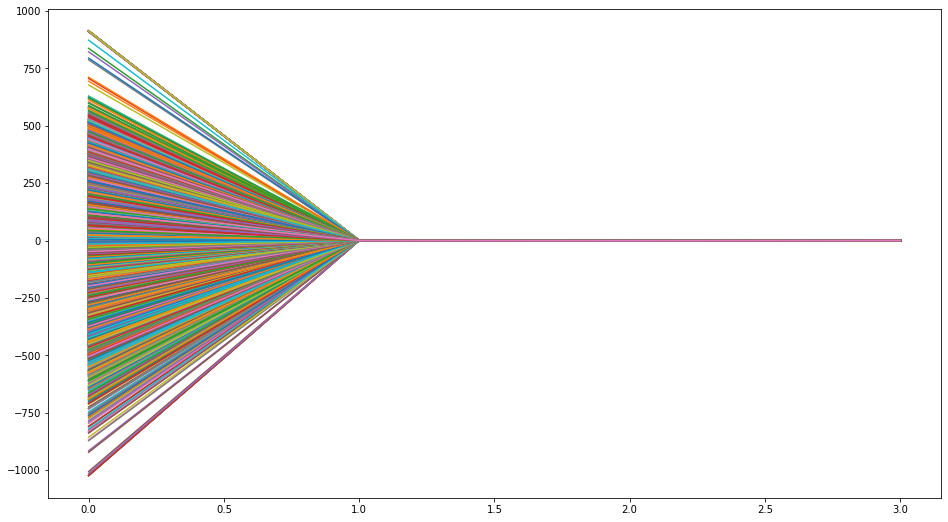

In [21]:
plt.figure(figsize=(16,9))
plt.plot(data)
plt.show()

In [22]:
ref_data = LoadTroikaRefFile(ref_files[0])

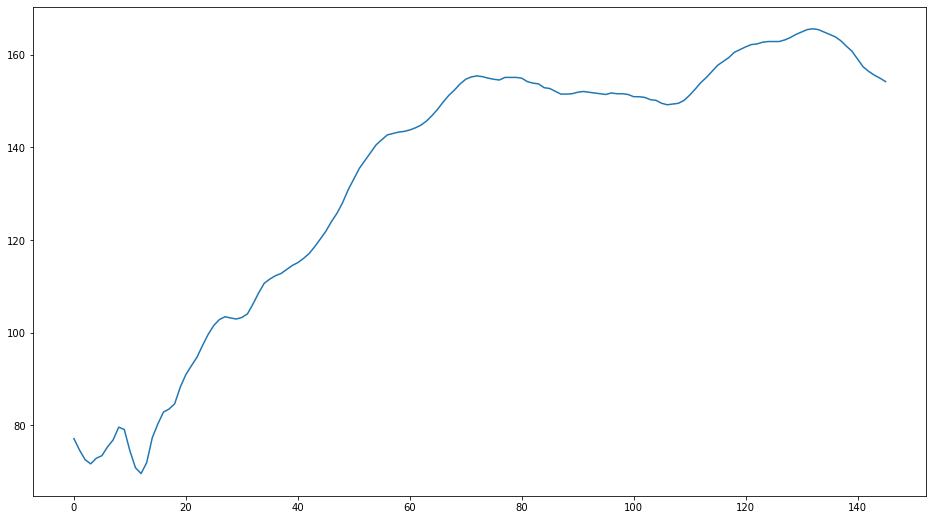

In [23]:
plt.figure(figsize=(16,9))
plt.plot(ref_data)
plt.show()

In [24]:
def BandpassFilter(signal, fs = 125):
    ''' Apply band pass filtering between 40 and 240 Hz'''
    ''' assumes pulse rate will be restricted between 40BPM (beats per minute) and 240BPM'''
    b, a = scipy.signal.butter(3, (40/60.0, 240/60.0), btype='bandpass', fs=fs)
    return scipy.signal.filtfilt(b, a, signal)

In [25]:
performance = Evaluate()
if performance < 10:
    print('Within the expected range {}'.format(performance))
else:
    print('Out of range {}'.format(performance))

Within the expected range 9.022239791683031


-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

##Code
How to run the Algorithm? 
Make sure to to have the folder ./datasets
Run all the cells. The last cell with Evalaute will run the algorithm and will evaluate the performance

##Data description
We used 3 axis (x, y, z) data from accelerometer and BPM data from PPG sensor. Both these are from the binary encoded .mat file. The code reads the files and extracts signal information using scipy API. 


##Algorithm
The Algorithm processes the signal information, identiies features, builds the model and
predicts the pulse rate, calculates the error and the confidence. 

#physiology advantage
Pulse rate is typically estimated by using the PPG sensor. When the ventricles contract, the capilaries in the wrist fill with blood. The (typically green) light emitted by the PPG sensor is absorbed by red blood cells in these capilaries and the photodetector will see the drop in reflected light. When the blood returns to the heart, fewer red blood cells in the wrist absorb the light and the photodetector sees an increase in reflected light. The period of this oscillating waveform is the pulse rate.

#algorithm outputs
The algorithm outputs confidence score of the prediction and the estimated frequency

#caveats

#common failure modes
One thing to note that the heart beating is not the only phenomenon that modulates the PPG signal. Blood in the wrist is fluid, and arm movement will cause the blood to move correspondingly. During exercise, like walking or running, we see another periodic signal in the PPG due to this arm motion. Our pulse rate estimator has to be careful not to confuse this periodic signal with the pulse rate.

#Performance
Used Random Forest Regressor with 200 estimators and max depht of 10 and applied Kfold with 5 splits. The metric that we use for calculating the performance was the mean absolute error (MAE)


-----
### Next Steps
You will now go to **Test Your Algorithm** (back in the Project Classroom) to apply a unit test to confirm that your algorithm met the success criteria. 